In [1]:
from datetime import datetime
from typing import Tuple, List, Union, Dict, Any
import json
import sys
import os
import uuid
import random

# Include subpath as module path
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

print("Module path: ", module_path)

from stream_handler import setup
setup()

import backend.disorientationdetectors as detectors

from backend.typealias import CoordinatePair, Sequence, Token, Pattern
import backend.datastructures as ds 
import backend.utils as utils
import backend.plotutils as plotutils
import backend.staypointdetector as spdetector
import backend.geohashsequenceinterpolator as ip
import backend.datapointstreamhandler as shandler
import backend.xchanges as xchanges
import backend.trajectorysegmentor as segmentor 
import backend.dataframeinterfaces as dfinterfaces
from django.conf import settings

import backend.models as django_models
import backend.managers as django_managers
from shapely.geometry import Polygon, Point

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

import pandas as pd
import numpy as np
import seaborn as sns
import msgpack

# Set the following flag such that we are able to run Django inside a jupyter notebook:
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

# Settings
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

bits_per_char = 2
center = [55.37356990358646, 10.40957265669214]
user = "d1b0c137-1cd0-4430-ad88-4dc24c88f3ad"

Module path:  /home/nicklasxyz/Desktop/traj-dirs/rtdm/RealtimeTrajectoryDataMining/rtdm


In [2]:
# Read in experimental data for case study 1
dfs = []
with open("data/case_study_1.json" ,"r") as f:
    data = json.load(f)
for item in data:
    temp_df = pd.read_json(item, orient = "split")
    for i in range(temp_df.shape[0]):
        df = pd.read_json(temp_df["df"].iloc[i] , orient = "split")
        df["external_timestamp"] = df.index
        temp_df["df"].iat[i] = df
    dfs.append(
        temp_df
    )

In [3]:
trajectories = []
for i in range(len(dfs)):
    for _, row in dfs[i].iterrows():
        df = row["df"]
        exchange = xchanges.InMemoryMessageExchangeWrapper()
        dpsh = shandler.InMemoryDataPointStreamHandler(
            **{
                "exchange": exchange,
                "max_merging_distance": 28,
                "max_radius": 100,
            },
        )
        detectors.bulk_insert_datapoint(df = df, user = user, exchange = exchange)
        trajectory = detectors.bulk_process_datapoint(
            user = user,
            exchange = exchange,
            dpsh = dpsh,
        )
        if len(trajectory) == 1:
            trajectory[0].uid = uuid.UUID(df["uid"].iloc[0])
        else:
            raise ValueError(
                "Expected only a single trajectory to be contained in the list!"
            )
        trajectories.extend(trajectory)
print(f"Read in a total of {len(trajectories)} trajectories")

Read in a total of 1 trajectories


In [4]:
dps = []
for datapoint in trajectories[0].datapoints:
    if len(datapoint.datapoints) > 0:
        for dp in datapoint.datapoints:
            dps.append(dp)
    else:
        dps.append(datapoint)

print("len(dps)                  : ", len(dps))
print("len(trajectory.datapoints): ", len(trajectories[0].datapoints))
print("Reduction                 : ", 100 * float(
    len(dps) - len(trajectories[0].datapoints) 
) / float(len(dps)), "%")

len(dps)                  :  1209
len(trajectory.datapoints):  390
Reduction                 :  67.74193548387096 %


In [5]:
map_ = plotutils.setup_map(center)
for trajectory in trajectories:
    map_ = trajectory.plot(center = center, map_ = map_)
map_

In [6]:
spd = spdetector.StayPointDetector(min_weight = 600, radius = 28, reference_user = user, **{"exchange": exchange})
spd.fit(trajectories = trajectories, user = user)
spd.plot(center = center, map_ = map_)

In [7]:
dp = trajectories[0].datapoints[0]
obj_list = []
traj_obj = django_models.Trajectory(
    start_timestamp = dp.external_timestamp,
    end_timestamp = None,
    user = user,
    tag = "raw", # Tag trajectory data as "raw"
)
traj_obj.save()
dps = trajectories[0].datapoints
traj_obj = django_models.Trajectory.objects.filter(user = user).last()  
traj_obj.start_timestamp = dps[0].external_timestamp
traj_obj.end_timestamp = dps[-1].external_timestamp
traj_obj.save(update_fields = ["start_timestamp", "end_timestamp"])
for dp in dps:
    dp_ = django_models.DataPoint(
        latitude = dp.latitude,
        longitude = dp.longitude,
        user = uuid.UUID(user), 
        label = None, 
        external_timestamp = dp.external_timestamp, 
        weight = dp.weight,
        # Nested datapoints are just saved as extra msgpack byte data
        datapoints = msgpack.dumps([_.to_dict() for _ in dp.datapoints]), 
        dx = dp.dx, 
        dt = dp.dt, 
        speed = dp.speed, 
        acceleration = dp.acceleration, 
        accuracy = dp.accuracy, 
    )
    # Associate each datapoint with the trajectory
    setattr(dp_, "trajectory", traj_obj)
    dp_.save()

In [8]:
def from_model(datapoint):
    """Convert Python DataPoint object to a Django database model object.
    """
    dict_ = datapoint.__dict__.copy()
    dict_["external_timestamp"] = str(dict_["external_timestamp"]) 
    dict_["user"] = str(dict_["user"])
    dict_["trajectory"] = dict_["trajectory_id"] 
    return ds.DataPoint.from_dict(dict_)

traj = ds.Trajectory([])
traj.datapoints = [from_model(_) for _ in traj_obj.datapoints.all()]
traj.uid = str(trajectory.uid)
traj.color = trajectory.color
traj.trajectory = str(trajectory.trajectory)
traj

In [9]:
onlinets = segmentor.TrajectorySegmentor(time_period = "2.5T", **{"exchange": exchange})
onlinets._segment_trajectory_offline(user = user, spd = spd, trajectories = [traj])

Saving 'BreakPoint' for trajectory:  d028fb80-133e-4831-9542-ffef9a72dc9a
Saving 'BreakPoint' for trajectory:  d028fb80-133e-4831-9542-ffef9a72dc9a
Saving 'BreakPoint' for trajectory:  d028fb80-133e-4831-9542-ffef9a72dc9a
Saving 'BreakPoint' for trajectory:  d028fb80-133e-4831-9542-ffef9a72dc9a
Saving 'BreakPoint' for trajectory:  d028fb80-133e-4831-9542-ffef9a72dc9a
Saving 'BreakPoint' for trajectory:  d028fb80-133e-4831-9542-ffef9a72dc9a
Saving 'BreakPoint' for trajectory:  d028fb80-133e-4831-9542-ffef9a72dc9a
Saving 'BreakPoint' for trajectory:  d028fb80-133e-4831-9542-ffef9a72dc9a
Saving 'BreakPoint' for trajectory:  d028fb80-133e-4831-9542-ffef9a72dc9a
Saving 'BreakPoint' for trajectory:  d028fb80-133e-4831-9542-ffef9a72dc9a
Saving 'BreakPoint' for trajectory:  d028fb80-133e-4831-9542-ffef9a72dc9a


In [10]:
traj_obj = django_models.Trajectory.objects.filter(user = user).last()  
subtrajectories = onlinets._segment_trajectory(user, traj_obj)

In [11]:
subtrajectories

In [12]:
counter = 0
map_ = plotutils.setup_map(center)
for trajectory in subtrajectories:
    random.seed(counter)
    trajectory.color = f"#{utils.color_hex(utils.rand_24_bit())}" 
    map_ = trajectory.plot(center = center, map_ = map_)
    counter += 1
map_

In [13]:
data = []
for trajectory in trajectories:
    for datapoint in trajectory.datapoints:
        dict_ = {
            "latitude": datapoint.latitude,
            "longitude": datapoint.longitude,
            "external_timestamp": datapoint.external_timestamp,
            "uid": trajectory.uid,
            "sub": 0,
        }
        data.append(dict_)
traj_df = pd.DataFrame(data = data)

data = []; counter = 1
for trajectory in subtrajectories:
    for datapoint in trajectory.datapoints:
        dict_ = {
            "latitude": datapoint.latitude,
            "longitude": datapoint.longitude,
            "external_timestamp": datapoint.external_timestamp,
            "uid": trajectory.uid,
            "sub": counter,
        }
        data.append(dict_)
    counter += 1
subtraj_df = pd.DataFrame(data = data)

In [14]:
sns.set_theme(style = "whitegrid")
sns.set_context("paper", font_scale = 1.75,  rc = {"lines.linewidth": 1.75})

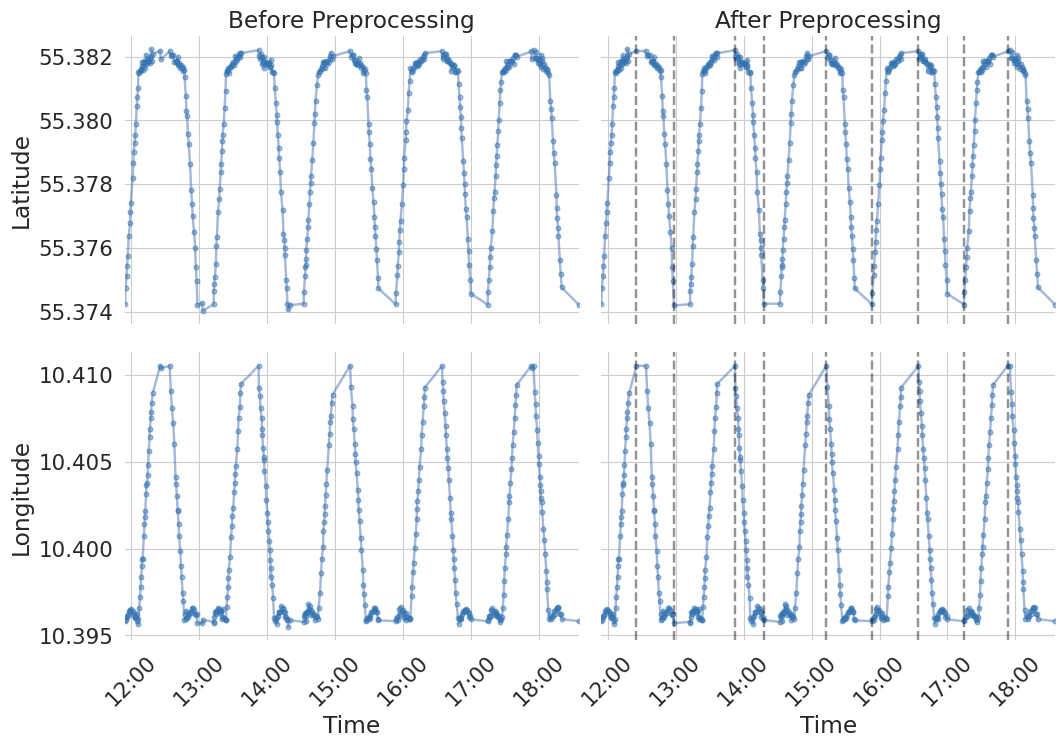

In [15]:
cp = sns.color_palette("tab10")
cp_list = list(cp.as_hex())

fig, axs = plt.subplots(2, 2, sharex = True, sharey = "row")

sns.lineplot(
    x = traj_df["external_timestamp"].values,
    y = traj_df["latitude"].values,
    dashes = False,
    ax = axs[0, 0],
    **{"marker": "o", "markersize": 3.5, "markeredgecolor": cp_list[0], "alpha": 0.5}
)

sns.lineplot(
    x = traj_df["external_timestamp"].values,
    y = traj_df["longitude"].values,
    dashes = False,
    ax = axs[1, 0],
    **{"marker": "o", "markersize": 3.5, "markeredgecolor": cp_list[0], "alpha": 0.5}
)

sns.lineplot(
    x = subtraj_df["external_timestamp"].values,
    y = subtraj_df["latitude"].values,
    dashes = False,
    ax = axs[0, 1],
    **{"marker": "o", "markersize": 3.5, "markeredgecolor": cp_list[0], "alpha": 0.5}
)
sns.lineplot(
    x = subtraj_df["external_timestamp"].values,
    y = subtraj_df["longitude"].values,
    dashes = False,
    ax = axs[1, 1],
    **{"marker": "o", "markersize": 3.5, "markeredgecolor": cp_list[0], "alpha": 0.5}
)

for _, _df in subtraj_df.groupby("sub"):
    if _ < 10:
        axs[0, 1].axvline(
            _df["external_timestamp"].values[-1],
            **{"color": "black", "alpha": 0.425, "linestyle": "--"},
        )
        axs[1, 1].axvline(
            _df["external_timestamp"].values[-1],
            **{"color": "black", "alpha": 0.425, "linestyle": "--"}
        )
    
axs[0, 0].set_ylabel("Latitude")
axs[1, 0].set_ylabel("Longitude")
axs[0, 0].set_title("Before Preprocessing")
axs[0, 1].set_title("After Preprocessing")

axs[1, 0].set_xlabel("Time")
axs[1, 1].set_xlabel("Time")

axs[1, 0].set_xlim(traj_df["external_timestamp"].values[0], traj_df["external_timestamp"].values[-1])
axs[1, 0].xaxis.set_major_locator(mdates.HourLocator())
axs[1, 0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[1, 0].tick_params(axis = "x", rotation = 45)

axs[1, 1].set_xlim(traj_df["external_timestamp"].values[0], traj_df["external_timestamp"].values[-1])
axs[1, 1].xaxis.set_major_locator(mdates.HourLocator())
axs[1, 1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[1, 1].tick_params(axis = "x", rotation = 45)

sns.despine(fig, left = True, bottom  = True, right = True, top = True)
plt.subplots_adjust(wspace=0.05, hspace=0.10)